In [90]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
from psycopg2.extras import execute_values
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from setuptools import setup, find_packages
import matplotlib.patches as patches
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [81]:
routed = pd.read_sql('''select * from congestion.agg_test''',con)

In [109]:
problem_routed = pd.read_sql('''with problem as (select segment_id, link_dir from (
select segment_id, id, unnest(link_set) as link_dir from congestion.test_pythonmerge)a
group by segment_id, link_dir
having count(link_dir) >1)
select distinct agg_test.* from congestion.agg_test
join problem using (segment_id)
order by segment_id 
''', con)

In [ ]:
if the length of a segment is one link then append
have to modify a little bit saying if the first one is shorter than whatever then we will append anyways

In [52]:
def handle_subsection(subsection, prev_i, max_segment_length=250.):
    # Scans through each subsection of `lengths`, grouping together
    # segments up to `max_segment_length`.
    subsec_segments = [{'idx': [prev_i, ], 'length': subsection[0]}]

    if len(subsection) > 1:
        for i, item in enumerate(subsection[1:]):
            if subsec_segments[-1]['length'] + item < max_segment_length or (i== 0 and subsec_segments[0]['length'] < 100):
                subsec_segments[-1]['idx'].append(i + prev_i + 1)
                subsec_segments[-1]['length'] += item
            elif subsec_segments[-1]['length'] + item > max_segment_length:
                subsec_segments.append({'idx': [i + prev_i + 1, ], 'length': item})

    return subsec_segments

In [111]:
# forward partition
max_multi_length = 250.
min_segment_length = 100.
for index, row in problem_routed.iterrows():
    segment_id = problem_routed['segment_id'].iloc[index].astype(float)
    lengths = problem_routed['length_set'].iloc[index]
    link_dir = problem_routed['link_set'].iloc[index]    
    segments = []
    segments.extend(handle_subsection(lengths, 0))
    segments = sorted(segments, key=lambda x: x['idx'][0])
    too_small = [i for i in range(len(segments)) if segments[i]['length'] < 100]
    n_deleted = 0

    for ir in too_small:
        i = ir - n_deleted
        if i == 0:
            segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
            segments[1]['length'] += segments[i]['length']
        elif i == len(segments) - 1:
            segments[-2]['idx'] += segments[i]['idx']
            segments[-2]['length'] += segments[i]['length']
        else:
            if segments[i - 1]['length'] >= segments[i + 1]['length']:
                segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
                segments[i + 1]['length'] += segments[i]['length']
            else:
                segments[i - 1]['idx'] += segments[i]['idx']
                segments[i - 1]['length'] += segments[i]['length']
        del segments[i]
        n_deleted += 1
    rows = []
    for i in range(len(segments)):
        id = i
        new_length = segments[i]['length']
        link_set = []
        for i in segments[i]['idx']:
            link_set.append(link_dir[i])
        row = (segment_id, id, link_set, new_length)
        rows.append(row) 
    sql = '''insert into congestion.test_pythonmerge_probs(segment_id, id, link_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)     

In [89]:
# original partition
max_multi_length = 300.
min_segment_length = 150.
for index, row in routed.iterrows():
    segment_id = routed['segment_id'].iloc[index].astype(float)
    lengths = routed['length_set'].iloc[index]
    link_dir = routed['link_set'].iloc[index]    
    segments = []

    prev_i = 0
    for i, item in enumerate(lengths):
        if item > max_multi_length:
            # Extract all lengths larger than `max_multi_length`.  These will be single-link segments.
            segments.append({'idx': [i, ], 'length': item})
            # Handle the subsections between large links using the functiona bove.
            if i != 0:
                segments.extend(handle_subsection(lengths[prev_i:i], prev_i, max_segment_length=max_multi_length))
                prev_i = i + 1
    # Handle subsection after last large link.
    segments.extend(handle_subsection(lengths[prev_i:], prev_i))
    # Sort according to first index in each subsection.
    segments = sorted(segments, key=lambda x: x['idx'][0])
    too_small = [i for i in range(len(segments)) if segments[i]['length'] < min_segment_length]
    
    # Handle deleting subsections that are too small.
    n_deleted = 0
    for ir in too_small:
        i = ir - n_deleted
        if i == 0:
            segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
            segments[1]['length'] += segments[i]['length']
        elif i == len(segments) - 1:
            segments[-2]['idx'] += segments[i]['idx']
            segments[-2]['length'] += segments[i]['length']
        else:
            if segments[i - 1]['length'] >= segments[i + 1]['length']:
                segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
                segments[i + 1]['length'] += segments[i]['length']
            else:
                segments[i - 1]['idx'] += segments[i]['idx']
                segments[i - 1]['length'] += segments[i]['length']
        del segments[i]
        n_deleted += 1

    rows = []
    for i in range(len(segments)):
        id = i
        new_length = segments[i]['length']
        link_set = []
        for i in segments[i]['idx']:
            link_set.append(link_dir[i])
        #insert to postgres
        row = (segment_id, id, link_set, new_length)
        rows.append(row)

    sql = '''insert into congestion.test_pythonmerge(segment_id, id, link_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)     

NameError: name 'execute_values' is not defined

In [272]:
segment_id = routed['segment_id'].iloc[8].astype(float)
lengths = routed['length_set'].iloc[8]
link_dir = routed['link_set'].iloc[8]    
max_multi_length = 300.
min_segment_length = 150.
segments = []

prev_i = 0
for i, item in enumerate(lengths):
    if item > max_multi_length:
        # Extract all lengths larger than `max_multi_length`.  These will be single-link segments.
        segments.append({'idx': [i, ], 'length': item})
        # Handle the subsections between large links using the function above.
        if i !=0:
            segments.extend(handle_subsection(lengths[prev_i:i], prev_i, max_segment_length=max_multi_length))
            prev_i = i + 1
        
# Handle subsection after last large link.
segments.extend(handle_subsection(lengths[prev_i:], prev_i))
# Sort according to first index in each subsection.
segments = sorted(segments, key=lambda x: x['idx'][0])
too_small = [i for i in range(len(segments)) if segments[i]['length'] < min_segment_length]

# Handle deleting subsections that are too small.
n_deleted = 0
for ir in too_small:
    i = ir - n_deleted
    if i == 0:
        segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
        segments[1]['length'] += segments[i]['length']
    elif i == len(segments) - 1:
        segments[-2]['idx'] += segments[i]['idx']
        segments[-2]['length'] += segments[i]['length']
    else:
        if segments[i - 1]['length'] >= segments[i + 1]['length']:
            segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
            segments[i + 1]['length'] += segments[i]['length']
        else:
            segments[i - 1]['idx'] += segments[i]['idx']
            segments[i - 1]['length'] += segments[i]['length']
    del segments[i]
    n_deleted += 1
segments

[{'idx': [0], 'length': 326.430064591479},
 {'idx': [0, 1, 2], 'length': 457.39379958515735}]

In [261]:
segment_id = routed['segment_id'].iloc[1].astype(float)
lengths = routed['length_set'].iloc[1]
link_dir = routed['link_set'].iloc[1]    
max_multi_length = 200.
ideal_length = 200
min_segment_length = 100.
segments = []  
print(lengths)
num_seg = (len(lengths))+1
current_length = 0
link = 0
link_inx = []
def add_segments(current_length, link):
    while current_length <= max_multi_length and link < num_seg:
        current_length = current_length + lengths[link]
        link_inx.append(link)
        link= link + 1
    return current_length, link_inx

leng, set = add_segments(current_length, link)
print(leng)
print(set)

def handle_subsection(subsection, prev_i, max_segment_length=300.):
    # Scans through each subsection of `lengths`, grouping together
    # segments up to `max_segment_length`.
    subsec_segments = [{'idx': [prev_i, ], 'length': subsection[0]}]

    if len(subsection) > 1:
        for i, item in enumerate(subsection[1:]):
            if subsec_segments[-1]['length'] + item > max_segment_length:
                subsec_segments.append({'idx': [i + prev_i + 1, ], 'length': item})
            else:
                subsec_segments[-1]['idx'].append(i + prev_i + 1)
                subsec_segments[-1]['length'] += item

    return subsec_segments

[107.091569964673, 108.072452093197, 137.035763134809, 197.162840750807, 153.795167067708, 161.310260719003, 229.838310195763, 76.245594341943, 71.3356179722374, 61.0890210600806, 100.165588797939, 91.0405410211722, 29.606433621624, 175.671410471163, 40.6122896299811, 19.3716214874113, 17.5173989308239, 40.5810681035119]
215.16402205787
[0, 1]


In [4]:
seg_list=[107.091569964673, 108.072452093197, 137.035763134809, 197.162840750807, 153.795167067708, 161.310260719003, 229.838310195763, 76.245594341943, 71.3356179722374, 61.0890210600806, 100.165588797939, 91.0405410211722, 29.606433621624, 175.671410471163, 40.6122896299811, 19.3716214874113, 17.5173989308239, 40.5810681035119]
def split_list(data, n):
    from itertools import combinations, chain
    for splits in combinations(range(1, len(data)), n-1):
        result = []
        prev = None
        for split in chain(splits, [None]):
            result.append(data[prev:split])
            prev = split
        yield result
        
possibility=list(split_list(seg_list,9))
len(possibility)

24310

Text(0, 0.5, 'Frequency')

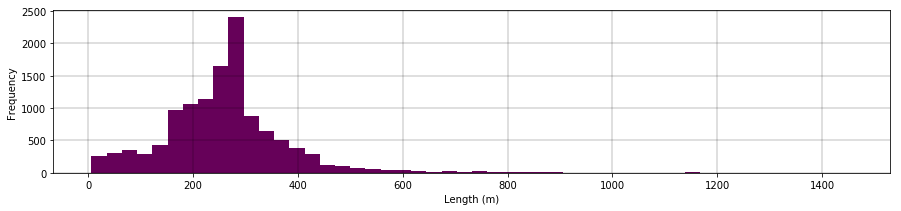

In [197]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''select length from congestion.pythonmerge_results''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.length, bins=50, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)
#plt.xlim((0,200))
plt.xlabel('Length (m)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

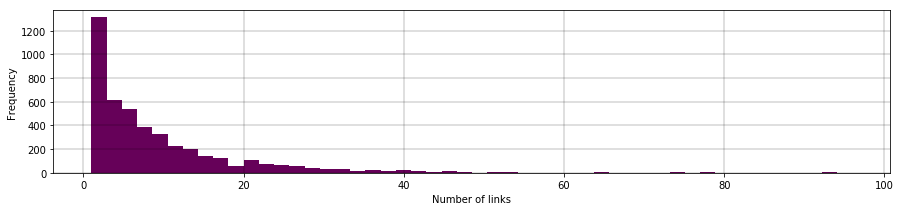

In [309]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''SELECT segment_id, length, count(link_dir) as num_link FROM congestion.segment_link_allint
inner join congestion.segments_test_allint using (segment_id)
group by segment_id, length	''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.num_link, bins=50, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)
#plt.xlim((0,200))
plt.xlabel('Number of links')
plt.ylabel('Frequency')

2931 rows with link_dir more than 3
1652 rows more than 10 possbilities 
1296 more than 50 possibilities
1113 more than 100 possibilities 

In [14]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''with temp as (																									 
SELECT segment_id, round(length::int/200.0,0)-1 as y, count(link_dir)-1 as x FROM congestion.segment_link_allint
inner join congestion.segments_test_allint using (segment_id)	
group by segment_id, length																									 
order by x desc)
, pos as (select (factorial(x)/(factorial(y)*(factorial(x-y))))::bigint as possibilities from temp where x >2)
select count(possibilities) filter (where possibilities <10) as "less than 10",
	count(possibilities) filter (where possibilities >= 10 and possibilities <100) as "less than 100",
	count(possibilities) filter (where possibilities >= 100 and possibilities <1000) as "1k",
	count(possibilities) filter (where possibilities >= 1000 and possibilities <10000) as "10k",
	count(possibilities) filter (where possibilities >= 10000 and possibilities <100000) as "100k",
	count(possibilities) filter (where possibilities >= 100000 and possibilities <1000000) as "1mil",
	count(possibilities) filter (where possibilities >= 1000000 and possibilities <10000000) as "10mil",
	count(possibilities) filter (where possibilities >= 10000000 and possibilities <100000000) as "100mil",
	count(possibilities) filter (where possibilities >= 100000000 and possibilities <1000000000) as "1billion",
	count(possibilities) filter (where possibilities >= 1000000000 and possibilities <10000000000) as "10billion",
	count(possibilities) filter (where possibilities >= 10000000000 and possibilities <100000000000) as "100billion",
	count(possibilities) filter (where possibilities >= 100000000000 and possibilities <1000000000000) as "trillion",
	count(possibilities) filter (where possibilities >= 1000000000000) as "more than a trillion"										  
from pos''',con)


In [16]:
duration_freq

,less than 10,less than 100,1k,10k,100k,1mil,10mil,100mil,1billion,10billion,100billion,trillion,more than a trillion
0,1167,633,407,240,153,102,55,48,37,28,16,14,13


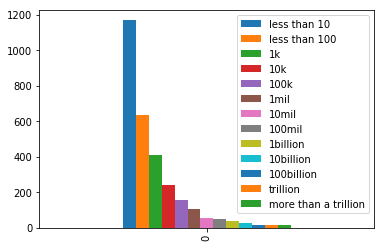

In [18]:
duration_freq.plot(kind='bar')